In [1]:
from __future__ import annotations

import json
import sys
from dataclasses import asdict, dataclass
from datetime import UTC, datetime
from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd
import torch

from src.utils.models import BuckConverterCell
from src.utils.plot_data import plot_u_vs_iL_vC


def find_repo_root(start: Path) -> Path:
    """pyproject.toml を目印にリポジトリルートを探す。"""
    for p in (start, *start.parents):
        if (p / "pyproject.toml").exists() and (p / "src").exists():
            return p
    raise FileNotFoundError(
        "pyproject.toml が見つからず、リポジトリルートを特定できません"
    )


repo_root = find_repo_root(Path.cwd())
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))


@dataclass(frozen=True)
class SimConfig:
    # 回路パラメータ（真値としてシミュレーションに使用）
    L: float = 200e-6
    C: float = 48e-6
    R: float = 10.0

    # 入力条件
    Vin: float = 20.0
    Vref: float = 12.0
    f_sw: float = 100_000.0

    # サンプリング条件
    samples_per_cycle: int = 200
    cycles: int = 1000

    # 初期状態
    iL0: float = 0.0
    vC0: float = 0.0

    # 保存先
    dataset_name: str = "buck_sim"

    @property
    def T(self) -> float:
        return 1.0 / float(self.f_sw)

    @property
    def duty(self) -> float:
        return float(self.Vref) / float(self.Vin)


def make_time_grid(
    T: float, cycles: int, samples_per_cycle: int
) -> tuple[np.ndarray, np.ndarray]:
    """t (N+1) と dt (N) を作る。"""
    n_steps = int(cycles) * int(samples_per_cycle)
    t = np.linspace(0.0, float(cycles) * float(T), n_steps + 1, dtype=np.float64)
    dt = np.diff(t)
    return t, dt


def make_switching_signal(t: np.ndarray, T: float, duty: float) -> np.ndarray:
    """スイッチング信号 u[k] を作る（0/1）。"""
    duty_phase = (t[:-1] % float(T)) / float(T)
    u = (duty_phase < float(duty)).astype(np.float64)
    return u


def simulate_buck(
    cell: BuckConverterCell,
    vs: np.ndarray,
    u: np.ndarray,
    dt: np.ndarray,
    iL0: float,
    vC0: float,
) -> tuple[np.ndarray, np.ndarray]:
    """BuckConverterCell を逐次適用して状態系列 (iL, vC) を返す。"""
    if not (len(vs) == len(u) == len(dt)):
        raise ValueError("vs/u/dt の長さが一致していません")

    x = torch.tensor(np.c_[vs, u, dt], dtype=torch.float32)

    iL_list: list[float] = []
    vC_list: list[float] = []

    with torch.no_grad():
        h = torch.tensor([[float(iL0), float(vC0)]], dtype=torch.float32)
        iL_list.append(float(h[0, 0].item()))
        vC_list.append(float(h[0, 1].item()))

        for k in range(x.shape[0]):
            h = cell(h, x[k : k + 1])
            iL_list.append(float(h[0, 0].item()))
            vC_list.append(float(h[0, 1].item()))

    return np.asarray(iL_list, dtype=np.float64), np.asarray(vC_list, dtype=np.float64)


def save_simulation_dataset(
    *,
    cfg: SimConfig,
    out_dir: Path,
    dataset_name: str,
) -> tuple[Path, Path]:
    """data/<dataset>/<dataset>.csv と <dataset>.json を保存する。"""
    out_dir.mkdir(parents=True, exist_ok=True)

    t, dt = make_time_grid(cfg.T, cfg.cycles, cfg.samples_per_cycle)
    u = make_switching_signal(t, cfg.T, cfg.duty)
    vs = np.full_like(u, fill_value=float(cfg.Vin), dtype=np.float64)

    cell = BuckConverterCell(L_init=cfg.L, C_init=cfg.C, R_init=cfg.R)
    iL, vC = simulate_buck(cell, vs, u, dt, cfg.iL0, cfg.vC0)

    # 1ステップ学習用に、(h_k, x_k) -> (h_{k+1}) が作れる形で保存
    df = pd.DataFrame(
        {
            "t": t[:-1],
            "t_next": t[1:],
            "dt": dt,
            "vs": vs,
            "u": u,
            "iL": iL[:-1],
            "vC": vC[:-1],
            "iL_next": iL[1:],
            "vC_next": vC[1:],
        }
    )

    dataset_base = out_dir / dataset_name
    csv_path = dataset_base.with_suffix(".csv")
    json_path = dataset_base.with_suffix(".json")

    df.to_csv(csv_path, index=False)

    meta: dict[str, Any] = {
        "generator": "actual_machine_notebooks/utils/create_csv_data.ipynb",
        "created_at": datetime.now(UTC).isoformat(),
        "model": "BuckConverterCell",
        "config": asdict(cfg) | {"T": cfg.T, "duty": cfg.duty},
        "n_steps": int(df.shape[0]),
        "columns": list(df.columns),
        "units": {
            "t": "s",
            "t_next": "s",
            "dt": "s",
            "vs": "V",
            "u": "-",
            "iL": "A",
            "vC": "V",
            "iL_next": "A",
            "vC_next": "V",
        },
    }

    json_path.write_text(
        json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8"
    )
    return csv_path, json_path


# =========================
# 実行（ここを必要に応じて変更）
# =========================
cfg = SimConfig(
    L=223.6e-6,
    C=73.8e-6,
    R=5.0,
    Vin=10.0,
    Vref=5.0,
    f_sw=1e5,
    samples_per_cycle=200,
    cycles=1000,
)
dataset_name = (
    f"buck_sim_Vin{cfg.Vin}_Vref{cfg.Vref}_fs{cfg.f_sw}_ppc{cfg.samples_per_cycle}_cyc{cfg.cycles}",
)[0]

# 再現性（乱数は使わないが、Torchの挙動固定用）
torch.manual_seed(0)

save_root = repo_root / "data" / dataset_name
csv_path, json_path = save_simulation_dataset(
    cfg=cfg, out_dir=save_root, dataset_name=dataset_name
)

# プロジェクトルートからの相対パスで表示
print(f"saved: {csv_path.relative_to(repo_root)}")
print(f"saved: {json_path.relative_to(repo_root)}")


saved: data/buck_sim_Vin10.0_Vref5.0_fs100000.0_ppc200_cyc1000/buck_sim_Vin10.0_Vref5.0_fs100000.csv
saved: data/buck_sim_Vin10.0_Vref5.0_fs100000.0_ppc200_cyc1000/buck_sim_Vin10.0_Vref5.0_fs100000.json


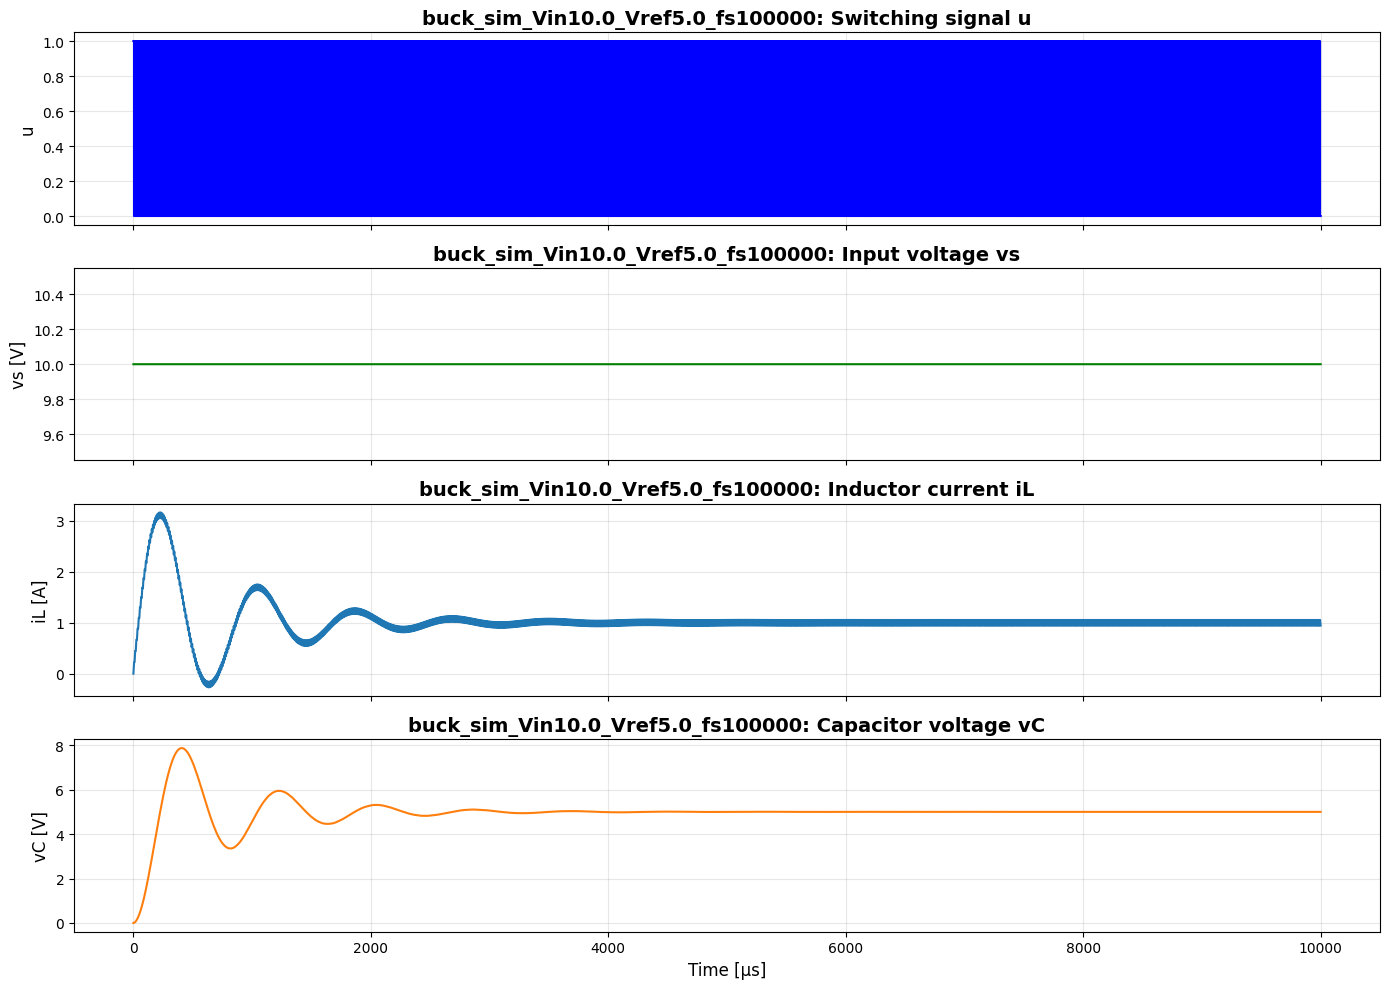

In [2]:
csv_file = Path(str(csv_path))
df = pd.read_csv(csv_file)


u = df["u"].to_numpy(dtype=np.float64)[:-1]
vs = df["vs"].to_numpy(dtype=np.float64)[:-1]
t = df["t"].to_numpy(dtype=np.float64)
iL = df["iL"].to_numpy(dtype=np.float64)
vC = df["vC"].to_numpy(dtype=np.float64)

fig, _ = plot_u_vs_iL_vC(t=t, u=u, vs=vs, iL=iL, vC=vC, title=csv_file.stem)
